### Leveraging explanation quality for model selection

In this notebook we are going to explore how, using **teex**, we can improve our model selection procedures. We follow the procedure described in [Jia et al. (2021)](https://dl.acm.org/doi/abs/10.1007/978-3-030-86520-7_43).

#### 0. Approach

Intuitively, a model that has a good predictive performance and makes decisions based on reasonable evidence is better than one that achieves the same level of accuracy but makes decisions based on circumstantial evidence. So, given an explanation model, we can investigate which evidence a model is basing its decisions on: a set of explanations will be of quality if it's based on reasonable evidence and of low quality otherwise. Then, given two models with similar predictive performance, we can leverage whether or not it is basing its decisions on good or bad evidence. With this intuition, we define a model scoring mechanism:

$$ score(f) = \alpha \cdot \text{score}_{acc}(f) + (1 - \alpha)\cdot \text{score}_{\text{explanation}}(f)$$

where $\alpha$ $\in[0, 1]$ is a hyperparameter, $f$ is the model being assessed and $\text{score}_{acc}(f)$ and $\text{score}_{\text{explanation}}(f)$ are accuracy and explanation scores, respectively. All models $f_1, ..., f_n$ will be assigned a score and we will choose based on it. **teex** will help us compute $\text{score}_{\text{explanation}}(f)$. From here, we will perform some experiments to see how correlated is the performance from models picked with this custom score with their performance on the test set.

In [1]:
random_state = 888

import teex.saliencyMap.data as sm_data
import teex.saliencyMap.eval as sm_eval

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import copy
import random
import pickle
import altair as alt
import pandas as pd

random.seed(random_state)
torch.manual_seed(random_state)

from sklearn import metrics, model_selection
from captum import attr
from captum.attr import visualization as viz
from torch import optim
from torchvision import models, transforms
from torch.utils import data
from scipy import stats

#### 1. Getting the data

We are going to work with a subset of the Oxford-IIIT Pet dataset, included in **teex**. It contains roughly 7000 images from 37 categories.

In [2]:
oxford_data = sm_data.OxfordIIIT()

We have the following classes available

In [3]:
oxford_data.classMap

{0: 'cat_Abyssinian',
 1: 'dog_american_bulldog',
 2: 'dog_american_pit_bull_terrier',
 3: 'dog_basset_hound',
 4: 'dog_beagle',
 5: 'cat_Bengal',
 6: 'cat_Birman',
 7: 'cat_Bombay',
 8: 'dog_boxer',
 9: 'cat_British_Shorthair',
 10: 'dog_chihuahua',
 11: 'cat_Egyptian_Mau',
 12: 'dog_english_cocker_spaniel',
 13: 'dog_english_setter',
 14: 'dog_german_shorthaired',
 15: 'dog_great_pyrenees',
 16: 'dog_havanese',
 17: 'dog_japanese_chin',
 18: 'dog_keeshond',
 19: 'dog_leonberger',
 20: 'cat_Maine_Coon',
 21: 'dog_miniature_pinscher',
 22: 'dog_newfoundland',
 23: 'cat_Persian',
 24: 'dog_pomeranian',
 25: 'dog_pug',
 26: 'cat_Ragdoll',
 27: 'cat_Russian_Blue',
 28: 'dog_saint_bernard',
 29: 'dog_samoyed',
 30: 'dog_scottish_terrier',
 31: 'dog_shiba_inu',
 32: 'cat_Siamese',
 33: 'cat_Sphynx',
 34: 'dog_staffordshire_bull_terrier',
 35: 'dog_wheaten_terrier',
 36: 'dog_yorkshire_terrier'}

We are going to work in a 4 class setting: let us choose some animals!

In [4]:
num_classes = 4
batch_size = 10
input_size = 224

iSi, lSi, eSi = oxford_data.get_class_observations(32) # Siamese cats
iMaine, lMaine, eMaine = oxford_data.get_class_observations(20) # Maine Coon cats
iJapChin, lJapChin, eJapChin = oxford_data.get_class_observations(17) # Japanese Chin dogs
iPinscher, lPinscher, ePinscher = oxford_data.get_class_observations(21) # Mini Pinscher dogs

classDict = {
    32: 0,
    20: 1,
    17: 2,
    21: 3
}

(-0.5, 276.5, 199.5, -0.5)

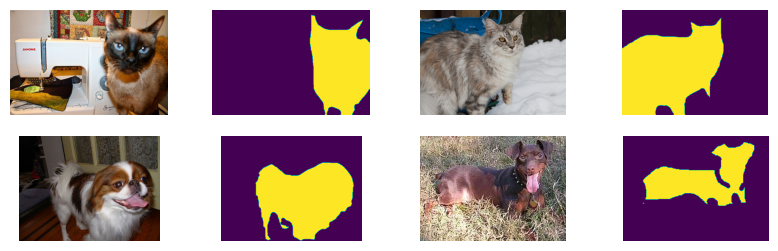

In [5]:
f, axarr = plt.subplots(2,4, figsize=(10, 3))

axarr[0,0].imshow(np.array(iSi[5]))
axarr[0,0].axis("off")
axarr[0,1].imshow(np.array(eSi[5]))
axarr[0,1].axis("off")

axarr[0,2].imshow(np.array(iMaine[0]))
axarr[0,2].axis("off")
axarr[0,3].imshow(np.array(eMaine[0]))
axarr[0,3].axis("off")

axarr[1,0].imshow(np.array(iJapChin[10]))
axarr[1,0].axis("off")
axarr[1,1].imshow(np.array(eJapChin[10]))
axarr[1,1].axis("off")

axarr[1,2].imshow(np.array(iPinscher[3]))
axarr[1,2].axis("off")
axarr[1,3].imshow(np.array(ePinscher[3]))
axarr[1,3].axis("off")

##### 1.1. Utils

Here are some utils that will be used later on. This notebook implements classes and methods that can be reused and are robust, so that later experimentation is

- easy
- replicable

In [4]:
def swap_to_original(im):
    """ Swap np.array from C*H*W to H*W*C or from W*H to H*W"""
    if len(im.shape) > 2:
        return np.swapaxes(np.swapaxes(im, 0, 2), 0, 1)
    else:
        return np.swapaxes(im, 0, 1)
    
def create_data(demo_data, exps, random_state, returnIndexes = False):
    """ Returns a dataloaders dict for training and two dicts:
        1. All data
        2. Explanations
        
        These dicts are indexed by the split (train / val / test). """
        
    data_length = len(demo_data)
    train_idx, test_idx = model_selection.train_test_split(list(range(data_length)), train_size=0.3, random_state=random_state)
    train_idx, val_idx = model_selection.train_test_split(train_idx, test_size=0.3, random_state=random_state)

    all_data = {}
    all_data['train'] = data.Subset(demo_data, train_idx)
    all_data['val'] = data.Subset(demo_data, val_idx)
    all_data['test'] = data.Subset(demo_data, test_idx)

    all_exps = {}
    all_exps['train'] = exps[train_idx]
    all_exps['val'] = exps[val_idx]
    all_exps['test'] = exps[test_idx]
    
    dataloaders_dict = {split: data.DataLoader(all_data[split], 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=0) for split in ['train', 'val', 'test']}
    
    if returnIndexes is True:
        return dataloaders_dict, all_data, all_exps, train_idx, val_idx, test_idx
    else:
        return dataloaders_dict, all_data, all_exps

def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False
        

def replace_layers(model, old, new):
    """ Many Captum attribution methods require
    ReLU operations to NOT be inplace. We will use this
    method to modify the pretrained model's behaviour. """
    
    for n, module in model.named_children():
        if len(list(module.children())) > 0:
            ## compound module, go inside it
            replace_layers(module, old, new)
        if isinstance(module, old):
            ## simple module
            try:
                n = int(n)
                model[n] = new
            except:
                setattr(model, n, new)
                
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

#### 2. Declaring our classifiers

We create a common model class that will help us perform the experiments and implement its logic. See how we use `teex` in the explanation evaluation function!

In [7]:
class Model:
    """ Our Model class. Training will be performed with 
    learning rate of 0.001 and momentum 0.9, using a standard gradient descent 
    optimizer and cross entropy loss. """
    
    def __init__(self, modelName: str, model: torch.nn.Module, 
                 input_size: int, random_state: int = 888) -> None:
        self.modelName = modelName
        self.model = model
        self.random_state = random_state
        self.input_size = input_size
        
        self._trained = False
        self._valid_explainers = ("ggcam", "sal", "gshap", "bp")
        self._latent_explainers = {
            "ggcam": attr.GuidedGradCam,
            "sal": attr.Saliency,
            "gshap": attr.GradientShap, 
            "bp": attr.GuidedBackprop
        }
        self._lr = 0.001
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._optim_momentum = 0.9
        self._optimizer = optim.SGD(self.model.parameters(), lr=self._lr, momentum=self._optim_momentum)
        self._criterion = torch.nn.CrossEntropyLoss()
        
    def train(self, dataloaders: dict, epochs: int = 10, 
              log_models: bool = False, verbose: bool = True) -> None:
        
        if self._trained:
            raise Exception("Model is already trained.")

        model_log = [] # contains deep copies of self at each training epoch

        for epoch in range(epochs):
            if verbose:
                print('Epoch {} / {}'.format(epoch + 1, epochs))
                print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self._device)
                    labels = labels.to(self._device)

                    # zero the parameter gradients
                    self._optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        outputs = self.model(inputs)
                        loss = self._criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            self._optimizer.step()

                    running_loss += loss.item() / inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if verbose:
                    print(f"{self.modelName} {phase} Loss {epoch_loss:.4f} Acc {epoch_acc:.4f}")
            
            if log_models:
                model_copy = copy.deepcopy(self)
                model_copy._trained = True
                model_log.append(model_copy)

        self._trained = True
        
        if log_models:
            return model_log
    
    def get_explanations(self, 
                         X: np.ndarray, 
                         method: str = "sal", 
                         expParams: dict = None,
                         attrParams: dict = None) -> np.ndarray:
        
        if self._check_is_trained() and self._check_explainer(method):
            if expParams is None:
                expParams = {}
            if attrParams is None:
                attrParams = {}
            explainer = self._get_explainer(method, **expParams)
            pred_labels = self.get_predictions(X)
            exps = explainer.attribute(inputs=X, target=pred_labels, **attrParams)
            retExps = []
            for exp in exps:
                swapped = swap_to_original(exp.detach().numpy())
                retExps.append(np.abs(viz._normalize_image_attr(swapped, 'positive', 2)))
            return np.stack(retExps)
        
    def get_predictions(self, X):
        if self._check_is_trained():
            _ , preds = torch.max(self.model(X), dim=1)
            return preds
    
    def compute_acc(self, gtY, y) -> float:
        scores = metrics.accuracy_score(y, gtY)
        return np.mean(scores)
    
    def compute_exp_score(self, gtExps, predExps) -> float:
        return sm_eval.saliency_map_scores(gtExps, predExps, metrics="auc")
    
    def compute_total_score(self, 
                            gtY: np.ndarray, 
                            y: np.ndarray, 
                            gtExps: np.ndarray, 
                            exps: np.ndarray,
                            alpha: float) -> float:
        
        return [alpha * self.compute_acc(gtY, y) + (1 - alpha) * self.compute_exp_score(gtExps, exps)][0][0]
    
    def _check_is_trained(self) -> bool:
        if self._trained:
            return True
        else:
            raise Exception("Model is not trained yet!")
        
    def _check_explainer(self, exp: str) -> bool:
        if exp not in self._valid_explainers:
            raise ValueError(f"Explainer {exp} is not valid. ({self._valid_explainers})")
        else:
            return True
        
    def _get_explainer(self, exp: str, **kwargs) -> bool:
        if kwargs is not None:
            explainer = self._latent_explainers[exp](self.model, **kwargs)
        else:
            explainer = self._latent_explainers[exp](self.model)
            
        return explainer

We then get 2 pre-trained models, modify them to our use case and initialize them.

In [8]:
def generate_models(num_classes, input_size):
    """ Instance a SqueezeNet and a ResNet18, both pretrained, and modify them to our 
    particular problem. """
    # SqueezeNet
    sqz = models.squeezenet1_0(weights="DEFAULT")
    set_parameter_requires_grad(sqz)
    replace_layers(sqz, nn.ReLU, nn.ReLU(inplace=False))
    sqz.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    sqz.num_classes = num_classes

    # ResNet18
    rnet = models.resnet18(weights="DEFAULT")
    set_parameter_requires_grad(rnet)
    replace_layers(rnet, nn.ReLU, nn.ReLU(inplace=False))
    num_ftrs = rnet.fc.in_features
    rnet.fc = nn.Linear(num_ftrs, num_classes)

    squeezeNet = Model("SqueezeNet", sqz, input_size)
    resNet = Model("ResNet18", rnet, input_size)
    
    return squeezeNet, resNet

#### 3. Preparing our data

Now, we are going to incorporate our data into a `torch.Dataset`, for easy batching and loading.
We also create the data splits and transform the observations to the model's required input size.

In [9]:
class DemoData(data.Dataset):
    """ A base Dataset class for compatibility with PyTorch """
    
    def __init__(self, data, labels) -> None:
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, slice):
        return self.data[slice], self.labels[slice]


def transform(images, input_size, normalize=True):
    
    """ Transformation of input images so that they work with our models.
    A resize, centering and a normalisation (only if the 
    images are not explanations) are performed. """
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size)
    ])
    
    if normalize:
        norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        d = [norm(transform(im)) for im in images]
    else:
        d = [transform(im) for im in images]
    return torch.stack(d, axis=0)


indexes = random.sample(list(range(len(iSi) + len(iPinscher) + len(iJapChin) + len(iMaine))), 
                        len(iSi) + len(iPinscher) + len(iJapChin) + len(iMaine))
ims, labs, exps = (iSi + iPinscher + iJapChin + iMaine, 
                   lSi + lPinscher + lJapChin + lMaine, 
                   eSi + ePinscher + eJapChin + eMaine)

original_images = transform([ims[idx] for idx in indexes], input_size, normalize=False)
ims = transform([ims[idx] for idx in indexes], input_size, normalize=True)
# transform labels from their class ID to [0, 1, 2, 3]
labs = torch.LongTensor([classDict[labs[idx]] for idx in indexes])
exps = np.squeeze(transform([exps[idx] for idx in indexes], input_size, normalize=False).numpy())

demo_data = DemoData(ims, labs)

now, using a previously declared utility function, creating the dataloaders is easy. By default, we are using a 20 / 10 / 70 split and a batch size of 10 on all experiments.

In [226]:
dataloaders_dict, all_data, all_exps, _, _, test_idx = create_data(demo_data, exps, random_state, returnIndexes = True)

We can easily train the models:

In [137]:
squeezeNet, resNet = generate_models(num_classes, input_size)

squeezeNet.train(dataloaders_dict, epochs=2)
resNet.train(dataloaders_dict, epochs=2)

Epoch 1 / 2
----------
SqueezeNet train Loss 0.0093 Acc 0.5893
SqueezeNet val Loss 0.0033 Acc 0.8889
Epoch 2 / 2
----------
SqueezeNet train Loss 0.0018 Acc 0.9167
SqueezeNet val Loss 0.0030 Acc 0.8750
Epoch 1 / 2
----------
ResNet18 train Loss 0.0132 Acc 0.4702
ResNet18 val Loss 0.0081 Acc 0.8611
Epoch 2 / 2
----------
ResNet18 train Loss 0.0046 Acc 0.9524
ResNet18 val Loss 0.0026 Acc 0.9861


With the models trained, we can also perform predictions and evaluate them in a straightforward manner:

In [138]:
test_preds = squeezeNet.get_predictions(all_data['test'][:][0])
test_acc = squeezeNet.compute_acc(test_preds, all_data['test'][:][1])
print(f"SqueezeNet: {round(test_acc * 100, 2)}% of test accuracy.")
test_preds = resNet.get_predictions(all_data['test'][:][0])
test_acc = resNet.compute_acc(test_preds, all_data['test'][:][1])
print(f"ResNet: {round(test_acc * 100, 2)}% of test accuracy.")

SqueezeNet: 91.43% of test accuracy.
ResNet: 98.57% of test accuracy.


We can also compute explanations with different explanation methods:

In [ ]:
pred_exps_sal = squeezeNet.get_explanations(all_data['test'][:5][0], method="sal")
pred_exps_bp = squeezeNet.get_explanations(all_data['test'][:5][0], method="bp")
pred_exps_ggcam = squeezeNet.get_explanations(all_data['test'][:5][0], 
                                              method="ggcam", 
                                              expParams={"layer": squeezeNet.model.features[12]})
pred_exps_gshap = squeezeNet.get_explanations(all_data['test'][:5][0], 
                                              method="gshap",
                                              attrParams={'baselines': torch.zeros((1, 3, input_size, input_size))})

Text(0.5, 1.0, 'GBackProp. expl.')

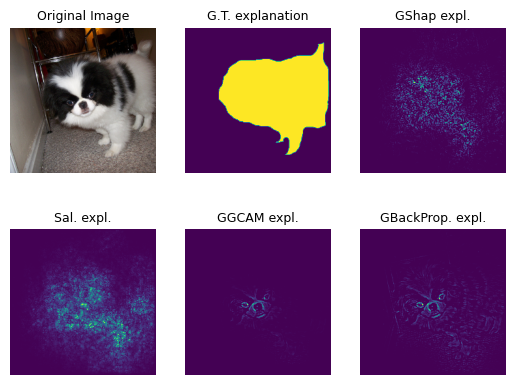

In [140]:
i = 4
f, axarr = plt.subplots(2, 3)
axarr[0,0].imshow(np.array(swap_to_original(original_images[test_idx][i])))
axarr[0,0].axis("off")
axarr[0,0].set_title('Original Image', fontsize=9)

axarr[0,1].imshow(np.array(all_exps['test'][i]))
axarr[0,1].axis("off")
axarr[0,1].set_title('G.T. explanation', fontsize=9)

axarr[0,2].imshow(pred_exps_gshap[i])
axarr[0,2].axis("off")
axarr[0,2].set_title('GShap expl.', fontsize=9)
                   
axarr[1,0].imshow(pred_exps_sal[i])
axarr[1,0].axis("off")
axarr[1,0].set_title('Sal. expl.', fontsize=9)

axarr[1,1].imshow(pred_exps_ggcam[i])
axarr[1,1].axis("off")
axarr[1,1].set_title('GGCAM expl.', fontsize=9)

axarr[1,2].imshow(pred_exps_bp[i])
axarr[1,2].axis("off")
axarr[1,2].set_title('GBackProp. expl.', fontsize=9)

Now we are ready to experiment.

#### 4. Performing the experiments

In this section we are going to put everything together. These are the steps to be followed in order to obtain our conclusions:

1. Randomly split our data into 20 / 10 / 70 train, validation and test sets.
2. Train our models for 10 epochs: we keep each epoch as a model configuration, leaving us with $N = 2\cdot 10$ models $f_1, ..., f_N$.
3. Evaluate, using our custom score function, each model $f_i$ with $\alpha \in \{0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1\}$ on the validation set. Note that we use GuidedGradCAM for the generation of explanations.
4. Compute the test accuracy for all models $f_i$.
5. Compute the Pearson correlation between the custom validation scores and test accuracy.
6. Repeat steps 1 to 5 (5 times) and average the correlations.

In [10]:
def experiment_epoch(data, explanations, alphas, random_state):
    """ Steps 1 to 5 of our experiment guide. Return correlations for each model f_i and alpha value. """
    
    # 1. split data
    dataloaders_dict, all_data, all_exps = create_data(data, explanations, random_state)
    correlations = {}
    
    for alpha_value in alphas:
        squeezeNet, resNet = generate_models(num_classes, input_size)
        evals = {}
        correlations[alpha_value] = {}
        
        # 2. train models
        sqzModels = squeezeNet.train(epochs=10, dataloaders=dataloaders_dict, log_models=True, verbose=False)
        resModels = resNet.train(epochs=10, dataloaders=dataloaders_dict, log_models=True, verbose=False)
        
        for model in sqzModels + resModels:
            if model.modelName not in evals:
                evals[model.modelName] = {}
                evals[model.modelName]['score'] = []
                evals[model.modelName]['acc'] = []
            # 3. get custom score on validation
            explainerLayer = model.model.layer4 if model.modelName == "ResNet18" else model.model.features[12]
            PredValExps = model.get_explanations(all_data['val'][:][0], 
                                                 method="ggcam", 
                                                 expParams={"layer": explainerLayer})
            valPreds = model.get_predictions(all_data['val'][:][0])
            score = model.compute_total_score(all_data['val'][:][1], valPreds,
                                              all_exps['val'][:], PredValExps, alpha_value)
            # 4. get accuracy on test
            testPreds = model.get_predictions(all_data['test'][:][0])
            testAcc = model.compute_acc(all_data['test'][:][1], testPreds)
            
            evals[model.modelName]['score'].append(score)
            evals[model.modelName]['acc'].append(testAcc)
            
        # 5. compute correlation
        for modelName in ["SqueezeNet", "ResNet18"]:
            corr, _ = stats.pearsonr(evals[modelName]['score'],
                                    evals[modelName]['acc'])
            correlations[alpha_value][modelName] = corr
            
    return correlations

We can now average the correlations from all 5 experiment epochs (the cell will take a while to finish computing):

In [ ]:
experiment_epochs = 5
final_corrs = {}
alphas = np.arange(0, 1.1, 0.1)

for i in range(experiment_epochs):
    corrs = experiment_epoch(demo_data, exps, alphas, random_state+i)
    for alpha, corrsDict in corrs.items():
        if alpha not in final_corrs:
            final_corrs[alpha] = {}
        for model, corr in corrsDict.items():
            if model not in final_corrs[alpha]:
                final_corrs[alpha][model] = [corr]
            else:
                final_corrs[alpha][model].append(corr)

# average results
for alpha, corrsDict in corrs.items():
    for model, corr in corrsDict.items():
        final_corrs[alpha][model] = sum(final_corrs[alpha][model]) / experiment_epochs

Optionally save and load the results:

In [15]:
with open("final_corrs", "wb") as f:
    pickle.dump(final_corrs, f)

In [61]:
with open("final_corrs", "rb") as f:
    final_corrs = pickle.load(f)

In [62]:
resultsDf = pd.DataFrame.from_dict(final_corrs)
alphas_beautyfied = [f"α = {round(alpha, 1)}" for alpha in alphas]
resultsDf.set_axis(alphas_beautyfied, axis=1).style.apply(highlight_max, axis=1)

,α = 0.0,α = 0.1,α = 0.2,α = 0.3,α = 0.4,α = 0.5,α = 0.6,α = 0.7,α = 0.8,α = 0.9,α = 1.0
SqueezeNet,0.913715,0.974938,0.959240,0.920658,0.964555,0.954114,0.897218,0.899346,0.900158,0.895084,0.849421
ResNet18,-0.330267,0.746659,0.785010,0.950277,0.813517,0.764662,0.821083,0.906087,0.813273,0.958297,0.965517


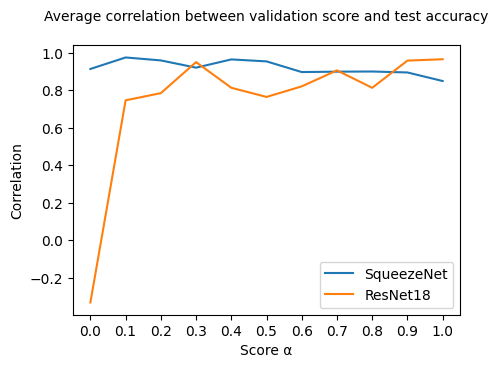

In [63]:
plt.figure(figsize=(5, 3.5))
plt.plot(resultsDf.transpose())
plt.xticks(alphas)
plt.xlabel("Score α")
plt.ylabel("Correlation")
plt.legend(["SqueezeNet", "ResNet18"])
plt.title("Average correlation between validation score and test accuracy\n", fontsize=10)
plt.show()

Here a few observations from our results:

1. Regarding the SqueezeNet model, performance on test seems to be more correlated to validation explanation quality than to validation accuracy, as can be seen by the steady drop for bigger $\alpha$ values. Having in mind that $\alpha = 1$ would mean that we only take into account accuracy and that $\alpha = 0$ would mean that we only consider explanation quality, we see that, on average, this model perform best with some, but not too much, explanation quality in the mix. 

2. Opposite to SqueezeNet, correlation between only explanation quality ($\alpha = 0$) and test performance is negative on the ResNet model. But, once we incorporate a little bit of accuracy information, this correlation goes up to competitive levels. Still, the most important maximums in the series are reached when $\alpha$ adds a little bit of validation accuracy and a lot of validation exp. quality and viceversa. This suggests that, for this particular model, explanation quality may not adding a lot of information.

#### 5. Next steps: the real world

Now that we have an intuition on how explanation quality can be leveraged for model selection, how do we proceed? In a real environment, one would have to consider how $\alpha$ is impacting results. In particular, as we cannot decide on a value ad-hoc, we could, for example, choose a range of values. With that range of values, one can:

- Use as definitive the most (best) frequent model whithin them
- Choose the top-k most frequent models and analyse their real-world performance on the go

Even better, we could find a way to better optimise $\alpha$ without the need to pick multiple models or sacrifing other models that could perform well. This is an interesting research question, and we look forward to seeing it evolve!

#### 6. Conclusion: what we've seen

This was quite a lot! Thank you for your time. Wrapping up, we want to briefly go over the points that this notebook addresses. In particular, this showcase mainly serves the purpose of

- Being a complex example of how `teex` can be used
- Showing how evaluating explanations in the way that `teex` proposes can be useful
- Showcasing the ease of use of both loading datasets and evaluating explanations with `teex`:
  Although everything surrounding it is complex, see how short the explanation evaluation function is on the class `Model`! We provide robust evaluation API's so that you can build whatever you like on top of them.

On a final note: the results reported here are not intended to be a representation of the ones from the paper in which the experiments were based. For more extensive results, check the paper out!